# Hydrating Twitter IDs!
#### More information on the Twitter IDs and the Twarc package can be found in the Sources section

In [1]:
# Read in necessary libraries and Packages
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
from pygeocoder import Geocoder
import reverse_geocoder as rg 
import pprint
from twarc import Twarc

# Text processing and LDA
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation as LDA

import pyLDAvis
import pyLDAvis.sklearn

C:\Users\John\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [ ]:
# # Pass in credentials so I can connect to API
# t = Twarc('HV2haozYztEHhD38iASch50lL', 
#           'XPaRlEkbZjnK5CLEW6pXmDzdKi5Bs3df4rFW9krmNJTg5YYPri',
#           '979782709298868224-Jw93XDCp5uzuKsD2kuQABD0QwdwnIb2', 
#           'duMEIGT0m1HhNLicPRS3m3eKgJ7FimvVX85egBYE7PW64')

# -----------------------------------------------------------------------------------------------------
# <u>Read in JSON Files and Parse JSON</u>
# -----------------------------------------------------------------------------------------------------

In [50]:
# The JSON file has thousands of JSON objects in it, so we need to first open the file, 
# loop through each line, and use the json.loads() function to extract each object
sample = 'randomsample5_round4'
tweets = []
with open("Twitter Data Sets\\GitHub Collected Data\\"+sample+".jsonl") as f:
    for line in f:
        tweets.append(json.loads(line))

In [51]:
# How many tweets do we have in this JSON file
len(tweets)

409730

In [52]:
backupcopy = tweets

### Number of keys in the json object

In [3]:
things = []
with open("Twitter Data Sets\\GitHub Collected Data\\some_april_tweets.json") as f:
    for line in f:
        things.append(json.loads(line))

In [45]:
w = str(things[0])
words = {}
for ws in w:
    if ws not in words:
        words[ws] = 1
    else:
        words[ws] += 1
print (words)

{'{': 22, "'": 380, 'c': 63, 'r': 148, 'e': 260, 'a': 167, 't': 230, 'd': 86, '_': 140, ':': 163, ' ': 306, 'W': 6, 'A': 5, 'p': 103, '0': 74, '1': 86, '5': 54, '4': 60, '+': 2, '2': 68, ',': 127, 'i': 190, '8': 31, '3': 47, '9': 42, '7': 55, '6': 20, 's': 145, 'f': 49, 'u': 90, 'l': 128, 'x': 28, 'H': 4, 'h': 51, '.': 51, '\\': 6, 'n': 126, 'J': 2, 'b': 42, 'm': 83, 'g': 78, 'k': 16, 'y': 18, 'o': 168, 'C': 4, '!': 3, 'M': 5, '?': 3, 'S': 9, '/': 102, 'V': 8, 'G': 9, 'E': 12, 'F': 25, '[': 12, ']': 12, 'w': 42, 'v': 20, 'U': 5, 'I': 6, 'N': 20, 'D': 7, 'X': 5, 'Q': 4, 'j': 6, 'z': 12, '}': 22, 'Z': 2, 'K': 1, '=': 4, '-': 4, 'R': 2, 'L': 1, 'P': 3, 'q': 3, '<': 2, '"': 4, '>': 2, 'T': 4, '🇲': 2, '🇨': 2, 'B': 2, 'O': 2}


In [50]:
print("There are {} keys (including nested keys) in the JSON object".format(words[':']))

There are 163 keys (including nested keys) in the JSON object


# Filter by Locations

In [5]:
# don't know if we can do 'washington' because of washington dc
locationsofinterest = ['seattle', 'spokane', 'tacoma', 'bellingham', 'tri cities', 'yakima', 'olympia',
                       'wa', 'washington state', 'seattle, wa', 'spokane, wa', 'tacoma, wa', 'bellingham, wa',
                       'tri cities, wa', 'yakima, wa', 'olympia, wa', 'seattle, washington', 'spokane, washington', 
                       'tacoma, washington', 'bellingham, washington', 'tri cities, washington', 'yakima, washington',
                       'olympia, washington',
                       'miami', 'tampa', 'tampa bay', 'jacksonville', 'orlando', 'fl', 'florida', 
                       'miama, fl', 'tampa, fl', 'tampba bay, fl', 'jacksonville, fl', ' orlando, fl', 
                       'miama, florida', 'tampa, florida', 'tampba bay, florida', 'jacksonville, florida',
                       ' orlando, florida']

In [53]:
# Splitting these out so that later I can index the valid_locs_coords by WA or FL tweets
valid_locs_location = [tweets[i]['user']['location'].lower().replace('\n', ' ').replace('\t', ' ').replace(r"[^\w\s']",' ').strip() in locationsofinterest for i in range(len(tweets))]
valid_locs_coords = [tweets[i]['coordinates'] != None for i in range(len(tweets))]

In [54]:
valid_tweets_location = list(pd.Series(tweets)[valid_locs_location])
valid_tweets_coords = list(pd.Series(tweets)[valid_locs_coords])

In [8]:
def reverseGeocode(coordinates): 
    result = rg.search(coordinates)
    return result

In [55]:
tuplecoords = [(valid_tweets_coords[i]['coordinates']['coordinates'][1], valid_tweets_coords[i]['coordinates']['coordinates'][0]) 
               for i in range(len(valid_tweets_coords))]

In [56]:
result = []
for i in range(len(valid_tweets_coords)):
    result.append(reverseGeocode(tuplecoords[i]))

In [57]:
state = []
for i in range(len(result)):
    state.append(result[i][0]['admin1'])

In [58]:
flindices = [i for i, x in enumerate(state) if x == "Florida"]
waindices = [i for i, x in enumerate(state) if x == 'Washington']

In [59]:
flindices, waindices

([65], [])

In [60]:
valid_florida = list(pd.Series(valid_tweets_coords)[flindices])
valid_washington = list(pd.Series(valid_tweets_coords)[waindices])
valid_fl_or_wa = valid_florida + valid_washington

In [61]:
all_valid_tweets = valid_tweets_location+valid_fl_or_wa

In [62]:
created_at = [all_valid_tweets[i]['created_at'] for i in range(len(all_valid_tweets))]
full_text = [all_valid_tweets[i]['full_text'] for i in range(len(all_valid_tweets))]
userid = [all_valid_tweets[i]['user']['id'] for i in range(len(all_valid_tweets))]
location = [all_valid_tweets[i]['user']['location'] for i in range(len(all_valid_tweets))]
coordinates = [all_valid_tweets[i]['coordinates'] for i in range(len(all_valid_tweets))]
retweeted_text = []
for i in range(len(all_valid_tweets)):
    try:
        retweeted_text.append(all_valid_tweets[i]['retweeted_status']['full_text'])
    except:
        retweeted_text.append('n/a')

In [63]:
output = pd.DataFrame({'created_at':created_at,'full_text':full_text,'userid':userid,'location':location,
             'coordinates':coordinates,'retweeted_text':retweeted_text})

In [64]:
output.to_csv("C:\\Users\\John\Desktop\\MSIM\\Spring Quarter 2020\\IMT 575\\Group Project\\twitter data sets\\CsvOutputs\\"+sample+".csv",
             encoding='utf-8', index=False)

<>:1: DeprecationWarning: invalid escape sequence \D
<>:1: DeprecationWarning: invalid escape sequence \D
<>:1: DeprecationWarning: invalid escape sequence \D
<ipython-input-64-ad467f48774e>:1: DeprecationWarning: invalid escape sequence \D
  output.to_csv("C:\\Users\\John\Desktop\\MSIM\\Spring Quarter 2020\\IMT 575\\Group Project\\twitter data sets\\CsvOutputs\\"+sample+".csv",


# -----------------------------------------------------------------------------------------------------
# END 
# -----------------------------------------------------------------------------------------------------

In [311]:
# tweets_coords_df = pd.DataFrame(valid_fl_or_wa)
# tweets_locs_df = pd.DataFrame(valid_tweets_location)
# valid_tweets_dataframe = tweets_coords_df.append(tweets_locs_df)
# valid_tweets_dataframe[['full_text', 'created_at', 'user', 'retweeted_status']]

In [263]:
#valid_locs = [tweets[i]['user']['location'].lower().replace('\n', ' ').replace('\t', ' ').replace(r"[^\w\s']",' ').strip() in locationsofinterest or 
#              tweets[i]['coordinates'] != None for i in range(len(tweets))]

In [264]:
tweets = list(pd.Series(tweets)[valid_locs])

In [268]:
# Turn list of JSON objects into a DataFrame
tweetsdf = pd.DataFrame(tweets)

#### Filter for users with coordinates

In [272]:
# Filter for only places that have valid user locations
tweetswithlocations = tweetsdf[[tweetsdf['coordinates'][i] != None for i in range(len(tweetsdf))]]
lons = [tweetswithlocations['coordinates'][i]['coordinates'][0] for i in tweetswithlocations.index]
lats = [tweetswithlocations['coordinates'][i]['coordinates'][1] for i in tweetswithlocations.index]
geometry = [Point(xy) for xy in zip(lons,lats)]
geodf = gpd.GeoDataFrame(geometry, columns = ['geometry'])

Text(0.5, 319.83753637500007, 'Longitude')

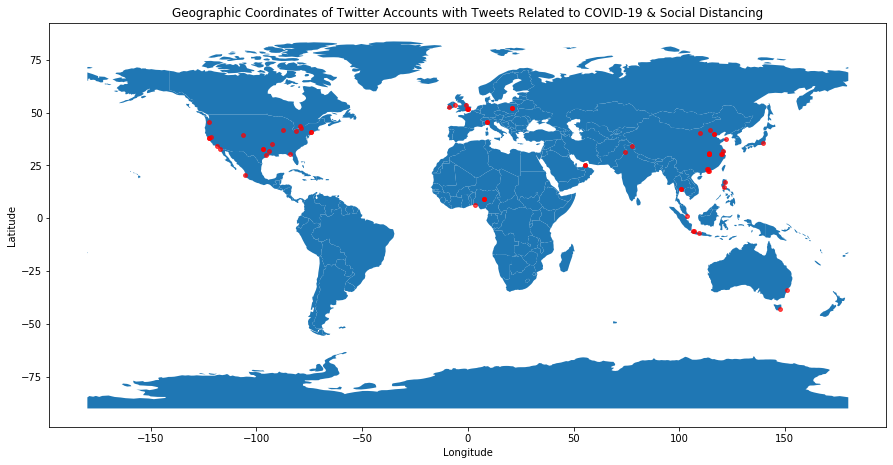

In [273]:
# Plot the points!
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

geodf.plot(ax=world.plot(figsize=(15,15)), marker = 'o', color = 'red', markersize = 15, alpha = .7)  
plt.title('Geographic Coordinates of Twitter Accounts with Tweets Related to COVID-19 & Social Distancing')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

#### TODO: Figure out how to put boundaries around WA and FL to include tweets from there

#### Filter for users with locations in Washington or Florida

In [23]:
# Filter for only places in Washington & Florida by user location
tweets_in_location = tweetsdf[[tweetsdf['user'][i]['location'].lower().replace('\n', ' ').replace('\t', ' ').replace(r"[^\w\s']",' ').strip() in locationsofinterest for i in range(len(tweetsdf))]]

In [26]:
[tweets_in_location['user'][i]['location'] for i in tweets_in_location.index]

['Florida',
 'Florida  ',
 'Seattle, WA',
 'miami',
 'Seattle',
 'Jacksonville, FL',
 'Tampa, FL',
 'Florida',
 'Florida',
 'WASHINGTON',
 'Florida',
 'Tampa, FL',
 'Seattle',
 'Tampa, FL',
 'Florida',
 'florida',
 'florida',
 'Florida',
 'Florida',
 'Seattle, WA',
 'Seattle',
 'Seattle, WA',
 'Seattle, WA',
 'Jacksonville, FL',
 'Florida',
 'Florida',
 'FL',
 'Florida',
 'Florida',
 'Florida',
 'Florida',
 'Florida',
 'Florida',
 'Florida',
 'Miami',
 'Bellingham, WA',
 'Washington State',
 'Florida',
 'Tampa, FL',
 'Seattle, WA',
 'Tampa, Fl',
 'Jacksonville, FL',
 'Florida',
 'FLORIDA',
 'Washington',
 'Florida',
 'Tampa, FL',
 'Jacksonville',
 'Tampa, Florida',
 'Miami',
 'Florida',
 'Tampa, FL',
 'Tampa Bay',
 'Florida',
 'Florida',
 'Florida',
 'Tampa, FL',
 'Florida',
 'Florida',
 'Tampa, FL',
 'Miami',
 'Florida',
 'Tampa, FL',
 'Tampa, FL',
 'miami',
 'Florida',
 'Tampa, Florida',
 'Tampa',
 'miami',
 'miami',
 'Tampa, FL',
 'Seattle, WA',
 'Seattle, WA',
 'Florida',
 'Seattle

#### Combine the dataframes with users with actual locations and those with locations listed in Washington or Florida
#### Still need to filter out the coordinates for those in WA or FL

In [ ]:
all_tweets_valid_locations = tweetswithlocations.append(tweets_in_location)
all_tweets_valid_locations.head()

#### Text pre-processing

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

In [ ]:
stopwords = stopwords.words('english')
extrastopwords = ['https', 'rt', 'april', 'jan', 'amp', 'co', '19', 'coronavirus', 'corona', 'covid', 'covid19',
                 'has']

In [ ]:
# Pre-process stopwords and tweets in the same way
stopwords = stopwords+extrastopwords
stopwords = [stopwords[i].lower() for i in range(len(stopwords))]
stopwords = [stopwords[i].replace('\n', ' ') for i in range(len(stopwords))]
stopwords = [stopwords[i].replace('\t', ' ') for i in range(len(stopwords))]
stopwords = [stopwords[i].replace(r"[^\w\s']", ' ') for i in range(len(stopwords))]
stopwords = [stopwords[i].strip() for i in range(len(stopwords))]

In [ ]:
#tweets = pd.Series([tweets[i]['full_text'] for i in range(len(tweets)) if tweets[i]['lang'] == 'en'])
tweet_text = pd.Series([all_tweets_valid_locations['full_text'][i] for i in all_tweets_valid_locations.index])

In [ ]:
# Pre-process stopwords and tweets in the same way
tweet_text = tweet_text.str.lower()
tweet_text = tweet_text.str.replace('\n', ' ')
tweet_text = tweet_text.str.replace('\t', ' ')
tweet_text = tweet_text.str.replace(r"[^\w\s']", ' ')
tweet_text = tweet_text.str.strip()
tweet_text = tweet_text[~tweet_text.isnull()]

In [ ]:
vec = CountVectorizer(stop_words = stopwords)
vec.fit(tweet_text)
counts = vec.transform(tweet_text)

In [ ]:
lda = LDA(n_components = 10, random_state = 11)
lda.fit(counts)
ldaOut = lda.transform(counts)

In [ ]:
p = pyLDAvis.sklearn.prepare(lda, counts, vec)

In [ ]:
pyLDAvis.save_html(p, 'Tweets_LDA.html')

In [ ]:
p

# -----------------------------------------------------------------------

## <u>Option 2 | Read in .txt Files & Hydrate them in a Jupyter Notebook</u>

#### First, Bring in .txt Files of Twitter IDs and Merging them
#### We have 4 folders (corresponding to Jan, Feb, Mar, Apr), each of which contains approx. 400-500 .txt files, and each file holds about 50k Twitter IDs that need to be hydrated. See example below for merging each text file in the April folder, resulting in a list with 405 sublists, each with thousands of Twitter IDs.

In [ ]:
filenames = []

for file in os.listdir('apriltweets'):
    filename = os.fsdecode(file)
    if filename.endswith( ('.txt') ):
        filenames.append(filename)

In [ ]:
ids = []
for file in filenames:
    with open('apriltweets\\'+file,'r') as tweetids:
        ids.append(tweetids.read())

In [ ]:
ids[0:2]

In [ ]:
testids = [ids[0][0:19], ids[0][20:39], ids[0][40:59]]
testids

#### Second, Hydrate the texts from within Jupyter Notebook - Warning: This goes much slower than using the app_auth in the command line, and rate limits are exceeded much quicker than when using using app_auth: https://github.com/DocNow/twarc

In [ ]:
jsontweets = []
for tweet in t.hydrate(ids[0]):
    jsontweets.append(tweet)
    
#for tweet in t.hydrate(open('ids.txt')):
#    print(tweet["text"])

In [ ]:
jsontweets

In [ ]:
testids = ['1245140084313206786', '1245140084350910464', '1245140084417941505']

In [ ]:
jsontweets = []
for i in t.hydrate(testids):
    jsontweets.append(i)

In [ ]:
jsontweets = json_normalize(jsontweets)

In [ ]:
jsontweets[['created_at', 'full_text', 'coordinates', 'user.location', 'retweeted_status.full_text']]

## <u>Option 3 | Read in .txt Files, merge them, write them to a new text file for hydrating in command line</u>

In [ ]:
# # Read in files
# filenames = []

# for file in os.listdir('twitter data sets\\tweetstohydratemay17'):
#     filename = os.fsdecode(file)
#     if filename.endswith( ('.txt') ):
#         filenames.append(filename)

In [ ]:
# # Read IDs from files
# ids = []
# for file in filenames:
#     with open('C:\\Users\\John\\Desktop\\MSIM\\Spring Quarter 2020\\IMT 575\\Group Project\\twitter data sets\\tweetstohydratemay17\\'+ file,'r') as tweetids:
#         ids.append(tweetids.read())

In [ ]:
# # Write the merged IDs to a new file
# with open('first_100_twitter_ids.txt', 'w') as outfile:
#     for i in ids[0:100]:
#         outfile.write(str(i))

#### Read in all TweetID Files and randomly select twitter IDs out of them

In [519]:
# Read in every single file with twitterids
filenames = []

for file in os.listdir('C:\\Users\\John\\Desktop\\TwitterIDs'):
    filename = os.fsdecode(file)
    if filename.endswith( ('.txt') ):
        filenames.append(filename)

In [516]:
### ROUND 1 ###
# Open each file, sample 4.5% of tweets, and append them to the ids list
# ids = []
# for file in filenames:
#     with open('C:\\Users\\John\\Desktop\\TwitterIDs\\'+ file, 'r') as tweetids:
#         tweetids = tweetids.read()
#         tweetids = tweetids.split('\n')
#         ids.append(random.sample(tweetids,int(np.ceil(len(tweetids)*.045))))

In [499]:
#ids_round1 = ids

In [526]:
#ids_round2 = ids

In [651]:
#ids_round3 = ids

In [652]:
used_ids = ids_round1 + ids_round2 + ids_round3

In [654]:
### ROUND 4 ###
# Open each file, sample 4.5% of tweets, and append them to the ids list
ids = []
for file in filenames:
    with open('C:\\Users\\John\\Desktop\\TwitterIDs\\'+ file, 'r') as tweetids:
        tweetids = tweetids.read()
        tweetids = tweetids.split('\n')
        tempids = []
        tempids.append(random.sample(tweetids,int(np.ceil(len(tweetids)*.045))))
        for i in tempids:
            if i not in used_ids:
                ids.append(i)

In [655]:
# Write the first 10% of sampled IDs to a new file
with open('randomsample1_round4.txt', 'w') as outfile:
    ids = [item for sublist in ids for item in sublist]
    for i in ids[0:int(len(ids)*.10)]:
        outfile.write(i + '\n')

In [656]:
#ids_round4 = ids

In [657]:
# Write the 10-20% of sampled IDs to a new file
with open('randomsample2_round4.txt', 'w') as outfile:
    for i in ids[int(len(ids)*.10):int(len(ids)*.20)]:
        outfile.write(i + '\n')

In [658]:
with open('randomsample3_round4.txt', 'w') as outfile:
    for i in ids[int(len(ids)*.20):int(len(ids)*.30)]:
        outfile.write(i + '\n')

In [659]:
with open('randomsample4_round4.txt', 'w') as outfile:
    for i in ids[int(len(ids)*.30):int(len(ids)*.40)]:
        outfile.write(i + '\n')

In [660]:
with open('randomsample5_round4.txt', 'w') as outfile:
    for i in ids[int(len(ids)*.40):int(len(ids)*.50)]:
        outfile.write(i + '\n')

In [661]:
with open('randomsample6_round4.txt', 'w') as outfile:
    for i in ids[int(len(ids)*.50):int(len(ids)*.60)]:
        outfile.write(i + '\n')

In [662]:
with open('randomsample7_round4.txt', 'w') as outfile:
    for i in ids[int(len(ids)*.60):int(len(ids)*.70)]:
        outfile.write(i + '\n')

In [663]:
with open('randomsample8_round4.txt', 'w') as outfile:
    for i in ids[int(len(ids)*.70):int(len(ids)*.80)]:
        outfile.write(i + '\n')

In [616]:
with open('randomsample9_round4.txt', 'w') as outfile:
    for i in ids[int(len(ids)*.80):int(len(ids)*.90)]:
        outfile.write(i + '\n')

In [664]:
with open('randomsample10_round4.txt', 'w') as outfile:
    for i in ids[int(len(ids)*.90)::]:
        outfile.write(i + '\n')

In [18]:
# %%timeit 
# tweets = []
# with open("Twitter Data Sets\\GitHub Collected Data\\some_april_tweets.json") as f:
#     for line in f:
#         tweet = json.loads(line)
#         fulltext = tweet['full_text']
#         tweets.append(fulltext)

11.6 s ± 787 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [200]:
# What the available data look like for one tweet
#tweets[27]

{'created_at': 'Wed Jan 22 02:44:06 +0000 2020',
 'id': 1219812956113756161,
 'id_str': '1219812956113756161',
 'full_text': 'CDC confirms first US case of coronavirus that has killed 6 in China https://t.co/rgbSxA2YBz 通过 @CNBCi',
 'truncated': False,
 'display_text_range': [0, 102],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'CNBCi',
    'name': 'CNBC International',
    'id': 19898168,
    'id_str': '19898168',
    'indices': [96, 102]}],
  'urls': [{'url': 'https://t.co/rgbSxA2YBz',
    'expanded_url': 'https://www.cnbc.com/2020/01/21/cdc-to-announce-first-us-case-of-china-coronavirus-that-has-killed-6-cnn-reports.html',
    'display_url': 'cnbc.com/2020/01/21/cdc…',
    'indices': [69, 92]}]},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_n

In [2]:
# tweets2 = []
# with open("Twitter Data Sets\\random_sample_tweets.jsonl") as f:
#     for line in f:
#         tweets2.append(json.loads(line))

### Text from Tweets

In [201]:
#[print(tweets[i]['full_text'] +'\n') for i in range(5)]

RT @CDCgov: New York City, Puerto Rico and 32 states are still experiencing high levels of #flu-like-illness, the latest #FluView report fr…

RT @OfficialJoelF: #BREAKING: @CNN reports the CDC will announce the first US case of this virus

RT @CDCgov: The first human infection with new #coronavirus (#2019-nCoV) has been reported in the US in a person who recently traveled to W…

RT @darhar981: First coronavirus case confirmed in US: CDC

https://t.co/CinuPqVwab

RT @StephenPunwasi: 😬 😬 😬

Remember when Ford cut a billion dollars from Toronto's public health? 🤔

A good portion of that was infectious…



[None, None, None, None, None]

In [202]:
# If a Tweet was retweeted, the text may be shortened. For example, in this tweet below the 'full text'
# is actually cut short, but in the retweeted status we can see the full text.
#print(tweets[27]['user']['location'], tweets[27]['full_text']), tweets[27]['retweeted_status']['full_text']

Malacca, Malaysia CDC confirms first US case of coronavirus that has killed 6 in China https://t.co/rgbSxA2YBz 通过 @CNBCi


KeyError: 'retweeted_status'

### Locations from Tweets

In [ ]:
# Printing out the first five user locations in the file
#[tweets[i]['user']['location'] for i in range(15)]

#### Let's see how many users have 'Seattle' as their exact location and what they tweeted.

In [7]:
text_tweets = pd.Series([tweets[i]['full_text'] for i in range(len(tweets))])
locations = pd.Series([tweets[i]['user']['location'] for i in range(len(tweets))])
seattle = pd.Series([tweets[i]['user']['location'] == 'Seattle' for i in range(len(tweets))])
full_text_tweets = []
for i in range(len(tweets)):
    try:
        full_text_tweets.append(tweets[i]['retweeted_status']['full_text'])
    except:
        full_text_tweets.append('n/a')
full_text_tweets = pd.Series(full_text_tweets)

In [9]:
print("There are {} users who have 'Seattle' as their location".format(len(locations[seattle])))

There are 172 users who have 'Seattle' as their location


In [ ]:
# Let's be more flexible with the location
flexible = pd.Series([tweets[i]['user']['location'] in ['Seattle','seattle', 'PNW', 'Seattle, Wa'] 
                      for i in range(len(tweets))])

In [ ]:
print("There are {} users who have 'Seattle', 'seattle', 'PNW', 'Seattle, Wa' as their location".format(len(locations[flexible])))

In [ ]:
for i in full_text_tweets[seattle]:
    print(i,'\n')

#### Clean up the locations

In [ ]:
locations = pd.Series([tweets[i]['user']['location'] for i in range(len(tweets))])
locations = locations.str.lower().str.replace('\n', ' ').str.replace('\t', ' ').str.replace(r"[^\w\s']",' ').str.strip()

In [ ]:
(len(tweets_in_location['full_text'])/len(tweets))*100

#### Locations are not great, but some users are geo_enabled and have coordinates.

In [274]:
tweets_coords = []
for i in tweets:
    if i['coordinates'] != None:
        tweets_coords.append(i)

In [275]:
len(tweets_coords)

67

#### 130 Users in this file have a geolocation

In [276]:
# Show the coordinates + location for one tweet 
tweets_coords[1]['user']['location'], tweets_coords[1]['coordinates']

('The City Of TRees', {'type': 'Point', 'coordinates': [-121.4947, 38.577]})

In [277]:
# Get all lats and lons and store them in a geopandas df for plotting
lats = [tweets_coords[i]['coordinates']['coordinates'][0] for i in range(len(tweets_coords))]
lons = [tweets_coords[i]['coordinates']['coordinates'][1] for i in range(len(tweets_coords))]
geometry = [Point(xy) for xy in zip(lats, lons)]
geodf = gpd.GeoDataFrame(geometry, columns = ['geometry'])
# Check it works
geodf.head()

,geometry
0,POINT (121.77137 16.93270)
1,POINT (-121.49470 38.57700)
2,POINT (-6.28035 53.36853)
3,POINT (139.65920 35.56180)
4,POINT (103.84317 1.28218)


In [278]:
def reverseGeocode(coordinates): 
    result = rg.search(coordinates)
    return result

In [279]:
tuplecoords = [(tweets_coords[i]['coordinates']['coordinates'][1], tweets_coords[i]['coordinates']['coordinates'][0]) 
      for i in range(len(tweets_coords))]

In [280]:
result = []
for i in range(len(tweets_coords)):
    result.append(reverseGeocode(tuplecoords[i]))

Loading formatted geocoded file...


In [281]:
placename = []
admin1 = []
admin2 = []
for i in range(len(result)):
    placename.append(result[i][0]['name'])
    admin1.append(result[i][0]['admin1'])
    admin2.append(result[i][0]['admin2'])

In [282]:
for i in range(len(result)):
    print(placename[i], ", ", admin1[i], ", " ,admin2[i])

Cauayan ,  Cagayan Valley ,  Province of Isabela
Sacramento ,  California ,  Sacramento County
Cabra ,  Leinster ,  
Kawasaki ,  Kanagawa ,  Kawasaki-shi
Singapore ,   ,  
London ,  England ,  Greater London
Wuhan ,  Hubei ,  
Warsaw ,  Masovian Voivodeship ,  Warszawa
Milano ,  Lombardy ,  Citta metropolitana di Milano
Guangzhou ,  Guangdong ,  
Abuja ,  Abuja Federal Capital Territory ,  
Tallahassee ,  Florida ,  Leon County
Bang Khen ,  Bangkok ,  
Wuhan ,  Hubei ,  
Sherman Oaks ,  California ,  Los Angeles County
Abuja ,  Abuja Federal Capital Territory ,  
Wuhan ,  Hubei ,  
Ikoyi ,  Lagos ,  
Sydney ,  New South Wales ,  City of Sydney
Grapevine ,  Texas ,  Tarrant County
San Francisco ,  California ,  San Francisco County
San Francisco ,  California ,  San Francisco County
Jingshan ,  Beijing ,  
Tegal ,  Central Java ,  
Yuen Long Kau Hui ,  Yuen Long ,  
Kangbao ,  Hebei ,  
Wuhan ,  Hubei ,  
Moganshan ,  Zhejiang Sheng ,  
Jakarta ,  Jakarta Raya ,  
New York City ,  New Y

In [285]:
flindices = [i for i, x in enumerate(admin1) if x == "Florida"]
waindices = [i for i, x in enumerate(admin1) if x == 'Washington']

In [286]:
flindices, waindices

([11], [])

### Sources
#### Twarc: https://github.com/DocNow/twarc
#### Twitter IDs: https://github.com/echen102/COVID-19-TweetIDs